# Synthetic Control

In 1988, California implemented Proposition 99, which imposed a 25-cent per pack excise tax on cigarettes and similar taxes on other tobacco products. To assess its impact, data from 39 states between 1970 and 2000 were analyzed, excluding states with similar tobacco control measures. One argument suggests that higher taxes raise cigarette prices, reducing demand, while the opposing view claims that due to addiction, price changes have little effect on demand, making cigarette demand inelastic. This implies that increased taxes mainly boost government revenue at smokers' expense.

This notebook is based on [Chapter 15 Synthetic Control](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html) and we will use the [pysyncon](https://sdfordham.github.io/pysyncon/synth.html) package.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pysyncon as sc

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

The data consists of 39 states and 30 years, with California being the only treated unit. The outcome variable is cigarette sales per capita. The goal is to estimate the causal effect of Proposition 99 on cigarette sales per capita in California. Since only one unit is treated, we cannot use difference-in-differences. Instead, we will combine the other states to build a *fake state* that resembles very closely the trend of California.

In [31]:
# Read data
# path_data = "https://github.com/matheusfacure/python-causality-handbook/raw/master/causal-inference-for-the-brave-and-true/data/"
# data = pd.read_csv(path_data + 'smoking.csv')
data_california = pd.read_stata("../data/smoking.dta")
data_california['year'] = data_california['year'].astype(int)
data_california

,state,year,cigsale,lnincome,beer,age15to24,retprice
0,Rhode Island,1970,123.900002,NaN,NaN,0.183158,39.299999
1,Tennessee,1970,99.800003,NaN,NaN,0.178044,39.900002
2,Indiana,1970,134.600006,NaN,NaN,0.176516,30.600000
3,Nevada,1970,189.500000,NaN,NaN,0.161554,38.900002
4,Louisiana,1970,115.900002,NaN,NaN,0.185185,34.299999
...,...,...,...,...,...,...,...
1204,New Mexico,2000,53.799999,NaN,NaN,NaN,279.799988
1205,Connecticut,2000,71.400002,NaN,NaN,NaN,312.299988
1206,Vermont,2000,88.900002,NaN,NaN,NaN,301.100006
1207,Ohio,2000,99.900002,NaN,NaN,NaN,265.399994


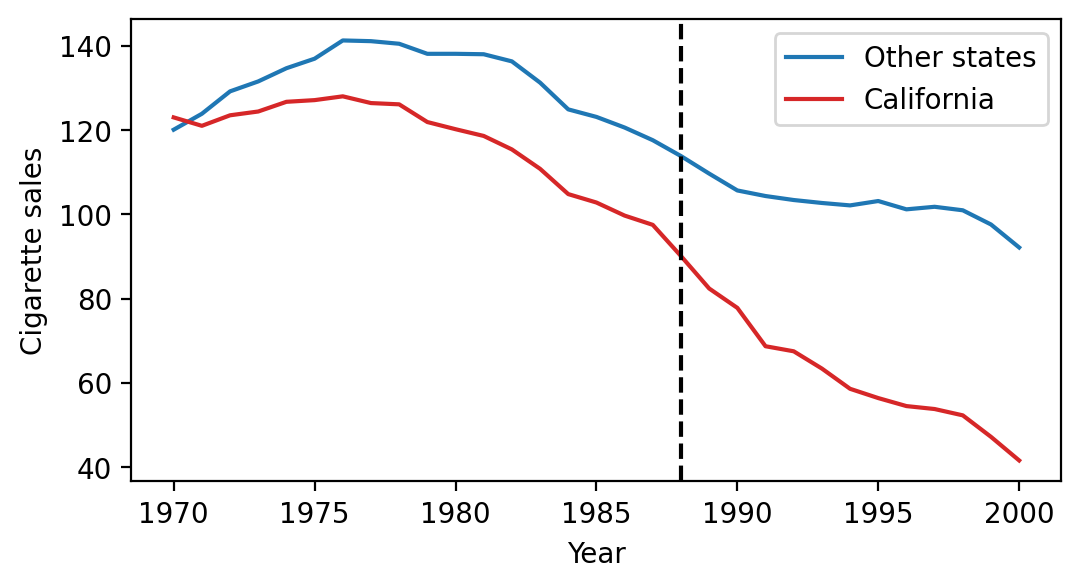

In [32]:
fig, ax = plt.subplots(figsize=(6, 3))

data_california['california'] = data_california['state'] == 'California'
data_california['treated'] = (data_california['year'] >= 1988) & data_california['california']
data_california.groupby(['california', 'year'])['cigsale'].mean().unstack().T.plot(ax=ax, color=['tab:blue', 'tab:red'])
ax.axvline(1988, color='black', linestyle='--')
ax.set_ylabel('Cigarette sales')
ax.set_xlabel('Year')
ax.legend(['Other states', 'California'])
plt.show()

Suppose that we have $J+1$ units. unit 1 gets affected by an intervention and units $j=2, \ldots, J+1$ are a collection of untreated units that we will refer to as the "donor pool". For each unit $j$ and each time $t$, we observe the outcome $Y_{j t}$. 

$Y_{j t}^N$ is the potential outcome without intervention and $Y_{j t^{\prime}}^I$, the potential outcome with intervention. Then, the effect for the treated unit $j=1$ at time $t$ is defined as

$$
\tau_{1 t}=Y_{1 t}^I-Y_{1 t}^N
$$

The challenge then becomes how do we estimate $Y_{1 t}^N$. Thus, a synthetic control is defined as a weighted average of the units in the control pool. Given the weights $\boldsymbol{W}=\left(w_2, \ldots, w_{J+1}\right)$, the synthetic control estimate of $Y_{1 t}^N$ is

$$
\hat{Y}_{1 t}^N=\sum_{j=2}^{J+1} w_j Y_{j t}
$$

We will restrict the weights to be positive and sum up to one. Thus, the synthetic control will be a convex combination of the units in the donor pool. When doing interpolation, we will project the treated unit in the convex hull defined by the untreated unit. We will use weights that minimize

$$
\left\|\boldsymbol{X}_1-\boldsymbol{X}_0 \boldsymbol{W}\right\|=\left(\sum_{h=1}^k v_h\left(X_{h 1}-\sum_{j=2}^{J+1} w_j X_{h j}\right)^2\right)^{\frac{1}{2}}
$$

subject to the restriction that $w_2, \ldots, w_{J+1}$ are positive and sum to one. Notice that $v_h$ reflect the importance of each variable when minimising the difference between the treated and the synthetic control.

In [33]:
states = data_california['state'].unique()
states = list(states[states != 'California'])

In [34]:
# Stata: synth cigsale beer(1984(1)1988) lnincome retprice age15to24 cigsale(1988) cigsale(1980) cigsale(1975), xperiod(1980(1)1988) trunit(3) trperiod(1989)

dataprep = sc.Dataprep(
    foo=data_california,
    predictors=['lnincome', 'retprice', 'age15to24'],
    predictors_op='mean',
    time_predictors_prior=range(1980, 1989),
    special_predictors=[
        ('beer', range(1984, 1989), 'mean'),
        ('cigsale', [1988], 'mean'),
        ('cigsale', [1980], 'mean'),
        ('cigsale', [1975], 'mean'),
        
    ],
    dependent='cigsale',
    unit_variable='state',
    time_variable='year',
    treatment_identifier='California',
    controls_identifier=states,
    time_optimize_ssr=range(1970, 1989),
)

print(dataprep)

Dataprep
Treated unit: California
Dependent variable: cigsale
Control units: Rhode Island, Tennessee, Indiana, Nevada, Louisiana, Oklahoma, New Hampshire, North Dakota, Arkansas, Virginia, Illinois, South Dakota, Utah, Georgia, Mississippi, Colorado, Minnesota, Texas, Kentucky, Maine, North Carolina, Montana, Vermont, Iowa, Connecticut, Kansas, Delaware, Wisconsin, Idaho, New Mexico, West Virginia, Pennsylvania, South Carolina, Ohio, Nebraska, Missouri, Alabama, Wyoming
Time range in data: 1970 - 2000
Time range for loss minimization: range(1970, 1989)
Time range for predictors: range(1980, 1989)
Predictors: lnincome, retprice, age15to24
Special predictors:
    `beer` over `range(1984, 1989)` using `mean`
    `cigsale` over `[1988]` using `mean`
    `cigsale` over `[1980]` using `mean`
    `cigsale` over `[1975]` using `mean`



In [35]:
synth = sc.Synth()
synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="equal")
weights = synth.weights()
weights[weights > 0]

Utah           0.098
Colorado       0.621
Connecticut    0.280
Delaware       0.001
Name: weights, dtype: float64

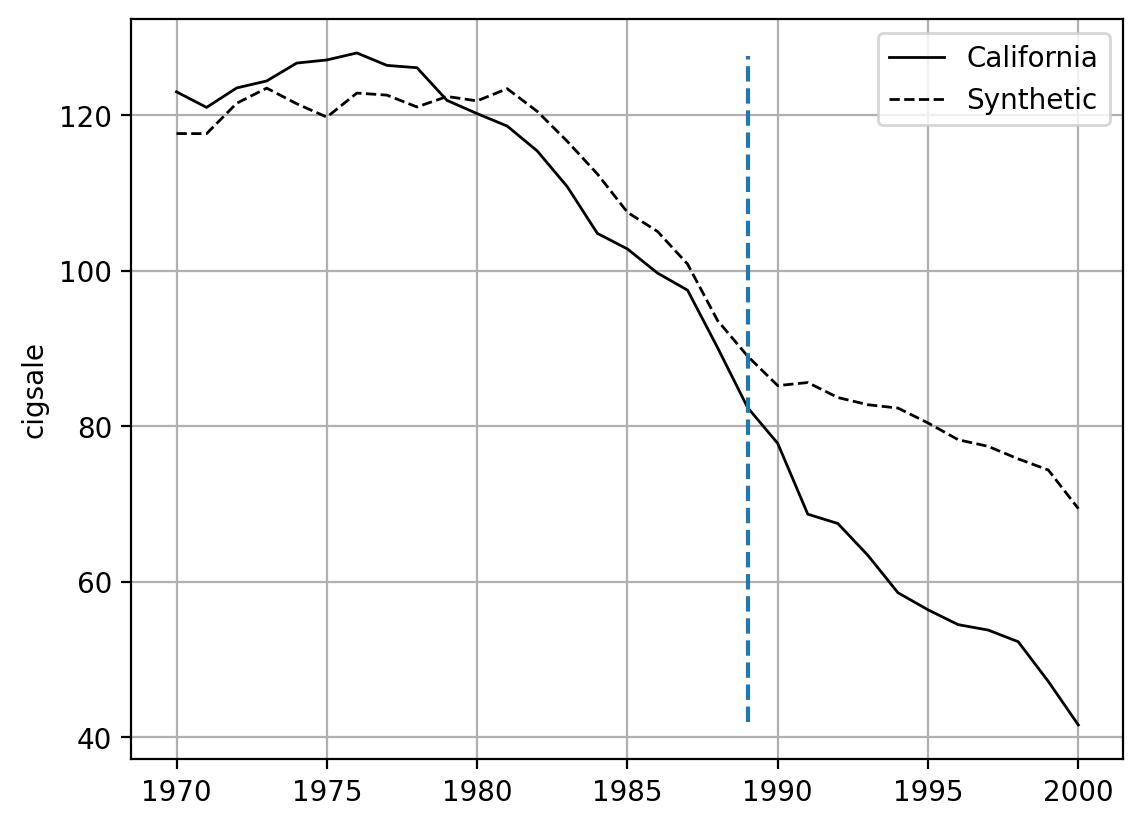

In [36]:
synth.path_plot(time_period=range(1970, 2001), treatment_time=1989)

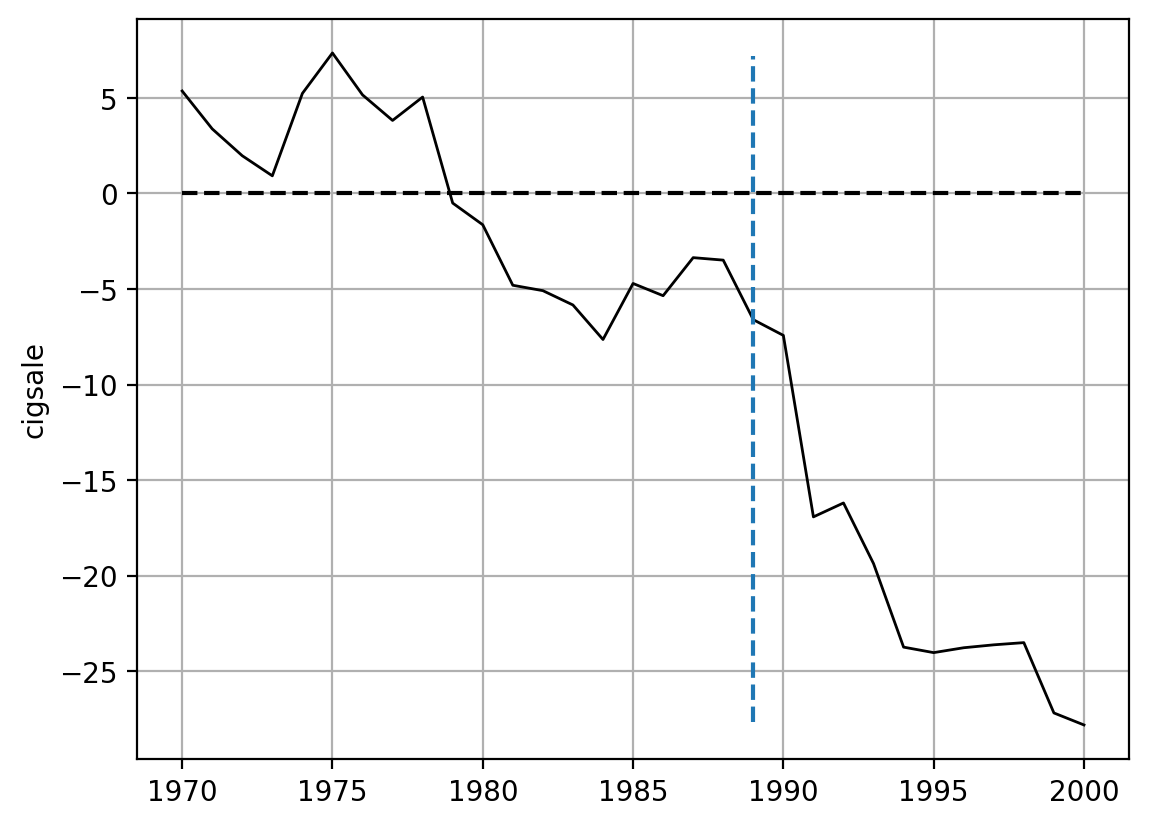

In [37]:
synth.gaps_plot(time_period=range(1970, 2001), treatment_time=1989)

In [38]:
synth.att(time_period=range(1989, 2001))

{'att': -20.016689503134113, 'se': 2.030649935254643}

In [39]:
synth.summary()

,V,treated,synthetic,sample mean
lnincome,0.080,10.077000,10.011,9.829000
retprice,0.190,89.421997,89.144,87.265999
age15to24,0.212,0.174000,0.172,0.173000
special.1.beer,0.012,24.280001,22.698,23.655001
special.2.cigsale,0.163,90.099998,93.590,113.823997
special.3.cigsale,0.178,120.199997,121.839,138.089005
special.4.cigsale,0.164,127.099998,119.749,136.932007


In [40]:
from synthlearners import Synth
from synthlearners.utils import prepare_panel

In [41]:
data = prepare_panel(
    data_california,
    unit_col='state',
    time_col='year',
    outcome_col='cigsale',
    treatment_col='treated',
)

Text(0.5, 1.0, 'Treatment matrix')

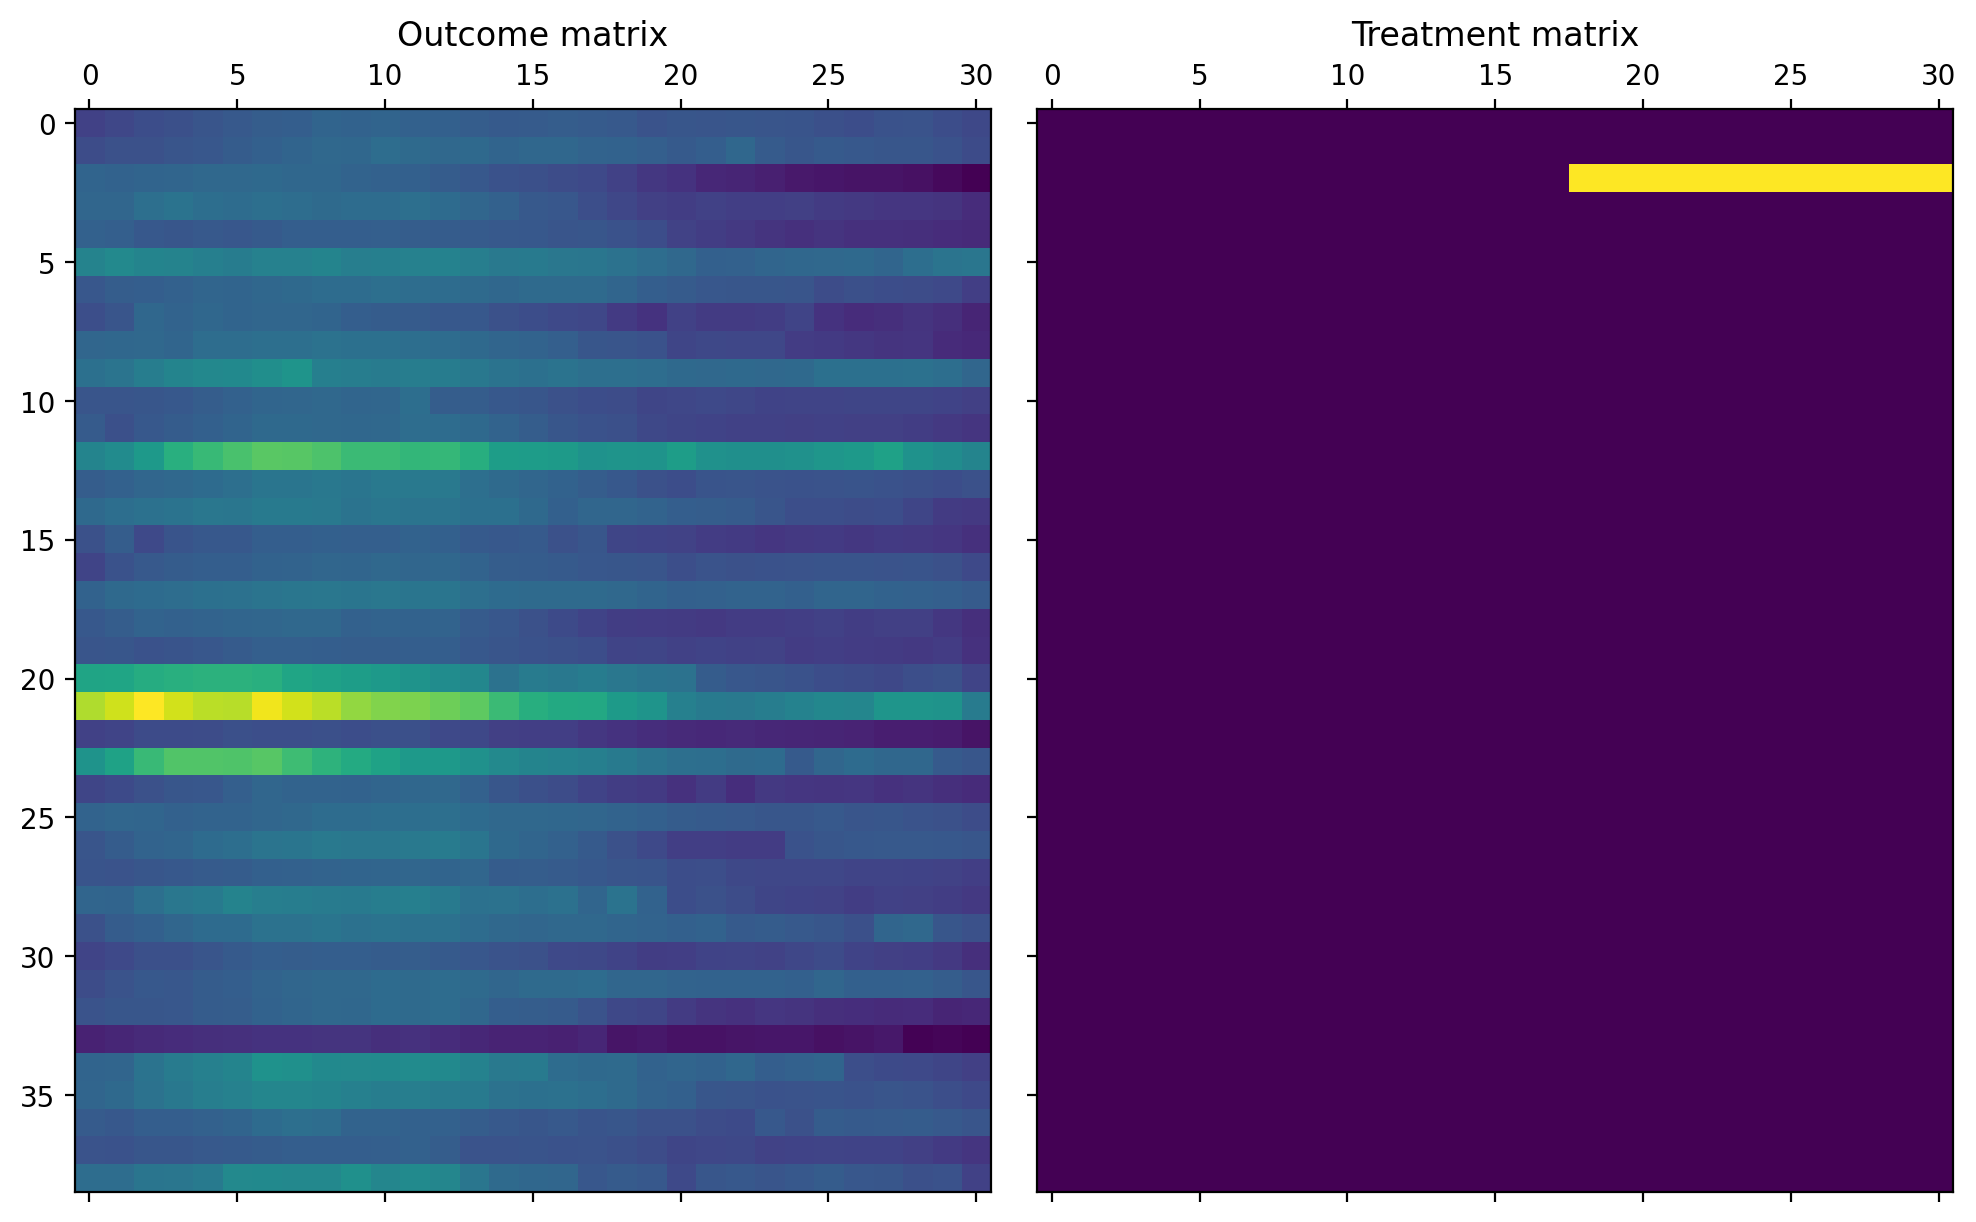

In [42]:
f, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ax[0].matshow(data["Y"], aspect="auto", cmap="viridis")
ax[1].matshow(data["W"], aspect="auto", cmap="viridis")
f.tight_layout()
ax[0].set_title("Outcome matrix")
ax[1].set_title("Treatment matrix")

In [43]:
# Fit synthetic control
synth = Synth(method="simplex")
results = synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
)

Computing permutation test:   0%|          | 0/38 [00:00<?, ?it/s]

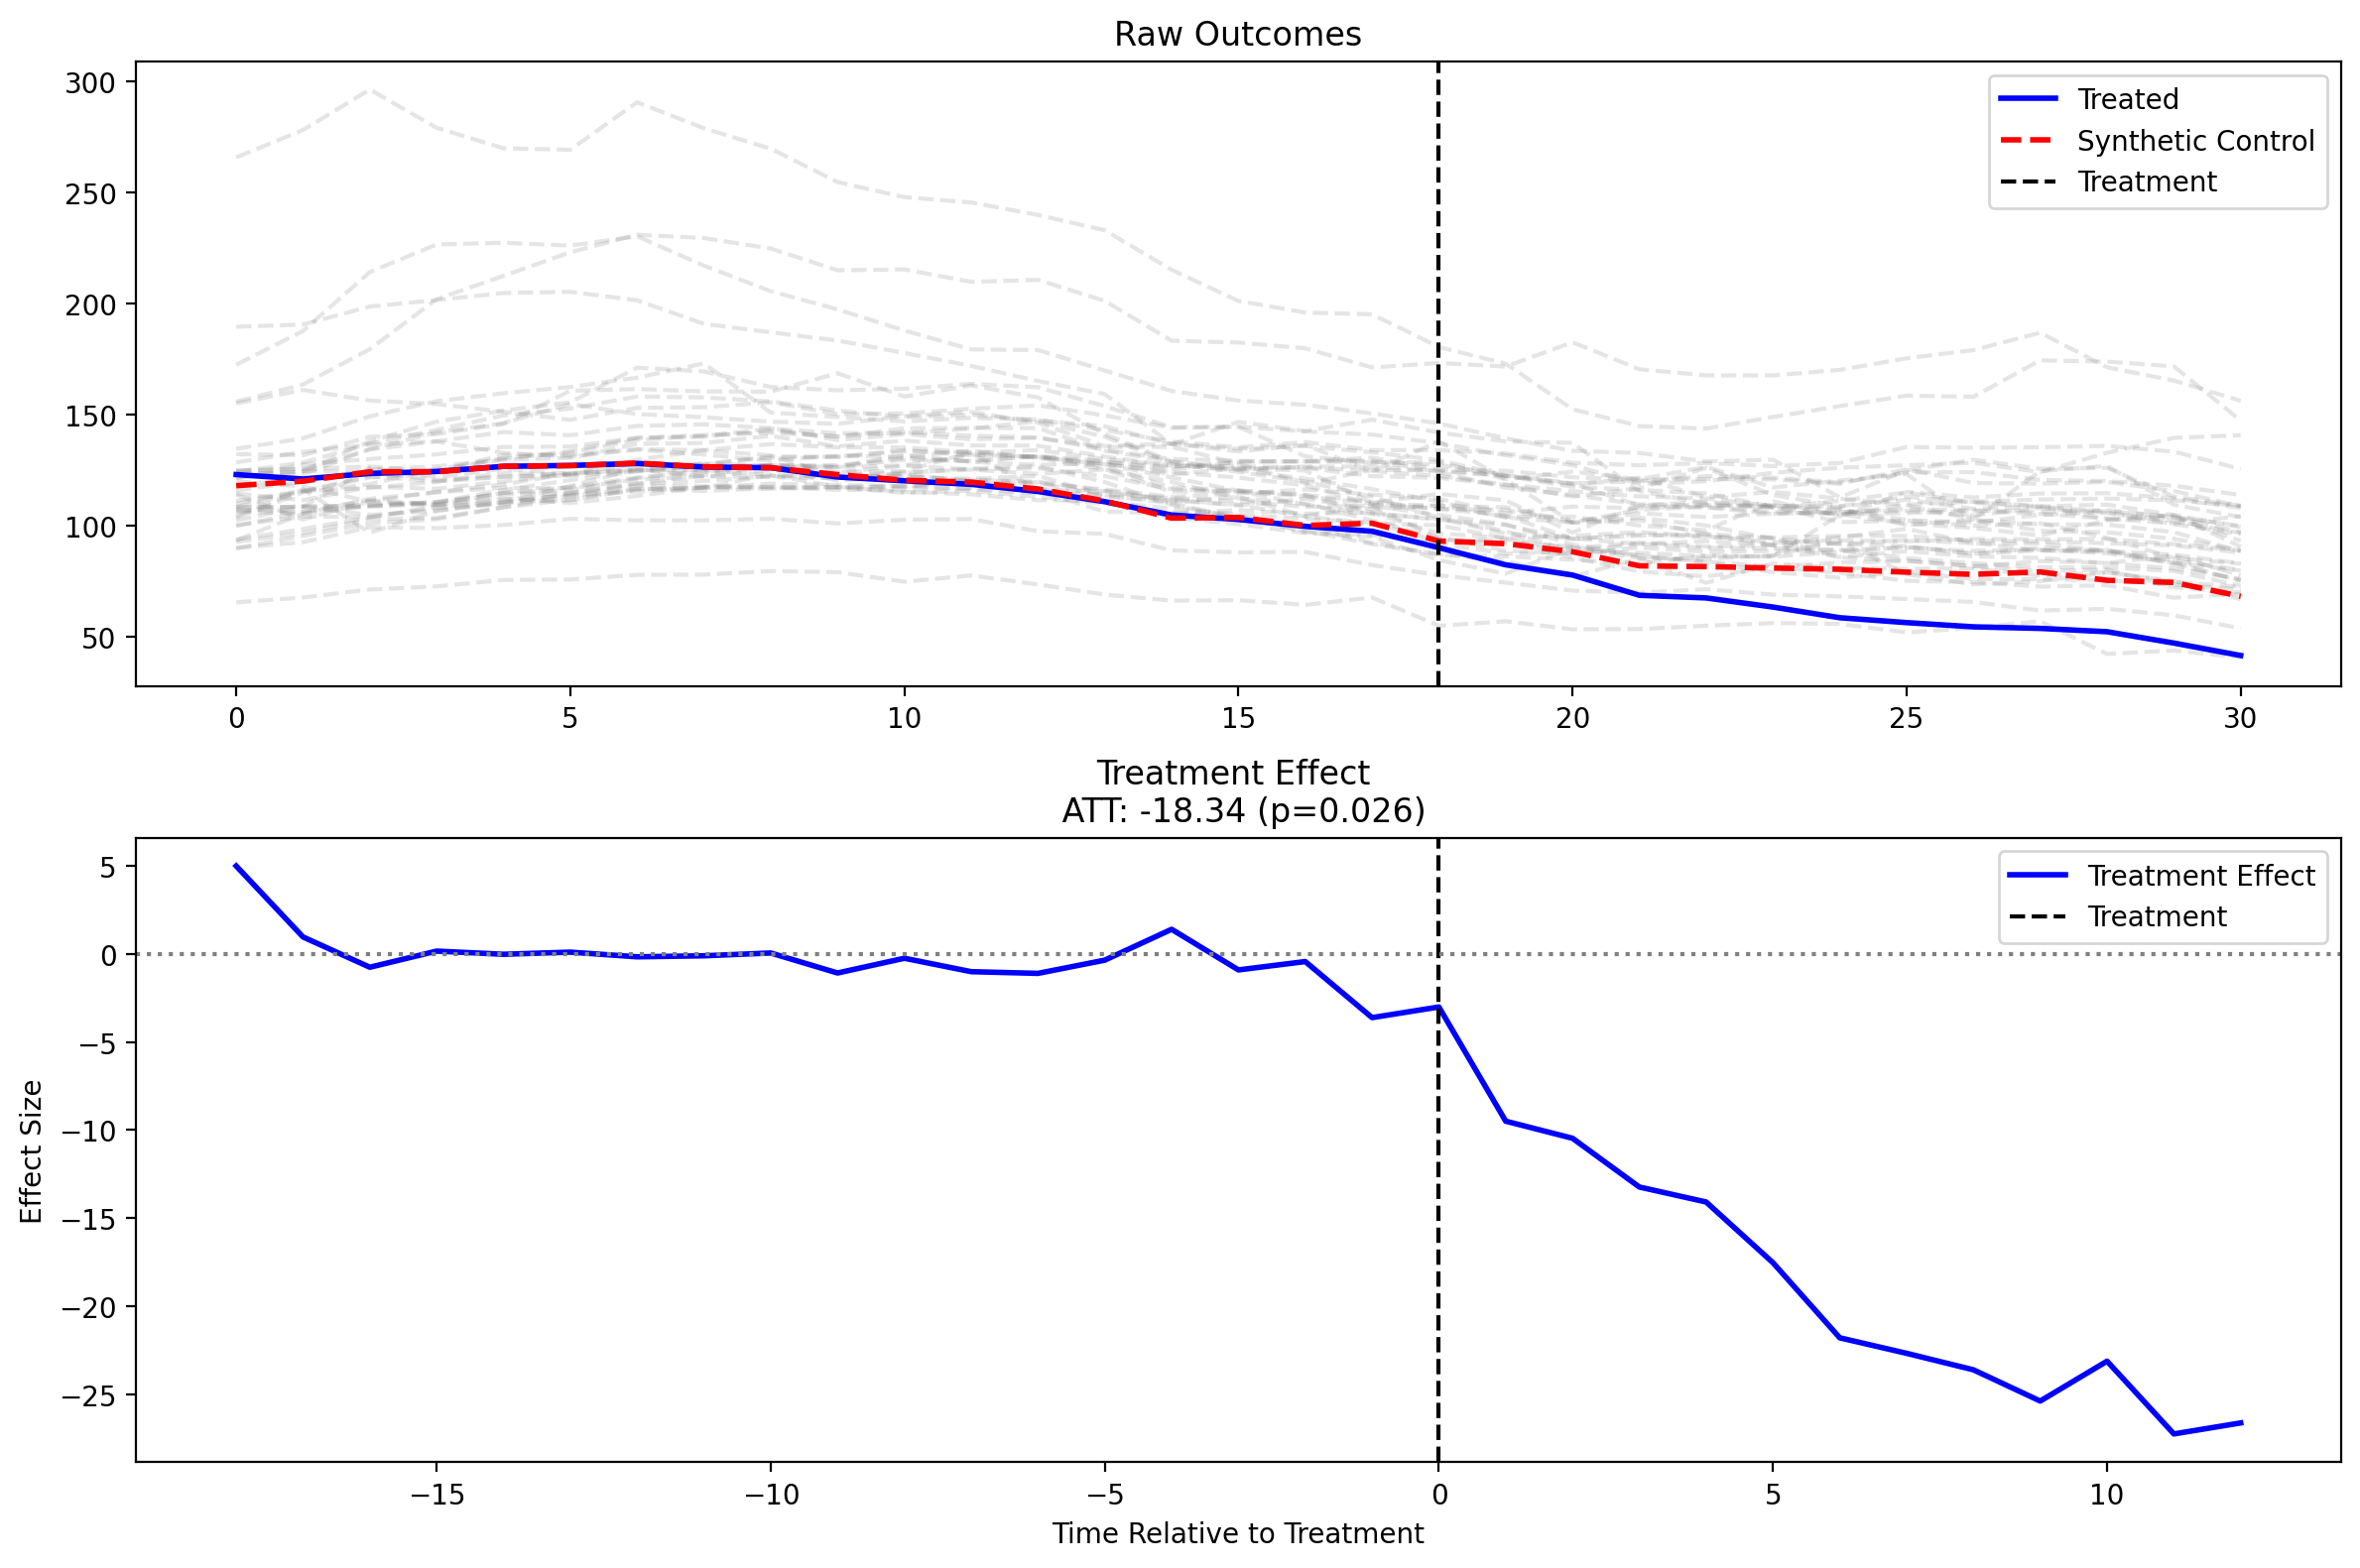

In [44]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Raw outcomes plot
synth.plot(results, data["Y"], data["treated_units"], data["T_pre"], mode="raw", ax=ax1)
ax1.set_title("Raw Outcomes")

# Treatment effect plot
synth.plot(
    results,
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    mode="effect",
    ax=ax2,
    show_ci=True,
)

plt.tight_layout()
plt.show()

https://github.com/MasaAsami/pysynthdid/blob/main/notebook/ReproductionExperiment_CaliforniaSmoking.ipynb

https://github.com/microsoft/SparseSC/blob/master/replication/sc2010.ipynb

https://github.com/sdfordham/pysyncon/blob/main/examples/basque.ipynb

https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html#synthetic-diff-in-diff